### *Exercise 2.5 (programming)*

#### Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the q*(a) start out equal and then take independent random walks (say by adding a normally  distributed increment with mean 0 and standard deviation 0.01 to all the q*(a) on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, ALPHA = 0.1. Use ÉPSILON = 0.1 and longer runs, say of 10,000 steps.

---
#### Resposta 1:

In [1]:
import random
import matplotlib.pyplot

In [2]:
class Bandit(object):
    '''
    One-armed bandit auto ajustável
    '''
    def __init__(self, mean = 0, variance = 1):
        self.__mean = 0
        self.__variance = 1
    
    def evaluate(self):
        return random.gauss(self.__mean, self.__variance)
    
    def adjust(self):
        self.__mean += random.gauss(0, 0.01)
    
    @property
    def variance(self):
        return self.__variance
    
    @property
    def mean(self):
        return self.__mean
    
    def __repr__(self):
        return "{0}(mean={1}, variance={2})".format(
                    self.__class__.__name__, self.__mean, self.__variance
                )

In [3]:
class Testbed():
        def __init__(self, k, epsilon, variances:list = None, seed=4):
            self.__arms = k
            self.__actions = [None] * (k)
            for i in range(k):
                variance = variances[i] if variances and variances[i] else 1
                self.__actions[i] = Bandit(0, variance=variance)
            self.__epsilon = epsilon
            self.__seed = seed
            random.seed(self.__seed)
        
        @property
        def k(self):
            return self.__arms

        @property
        def epsilon(self):
            return self.__epsilon
        
        @property
        def seed(self):
            return self.__seed

        def evaluate(self, action: int):
            if not (action < len(self.__actions)):
                raise IndexError("Ação escolhida inválida: {}".format(action))
            rewards = [i.evaluate() for i in self.__actions]
            R = rewards[action]
            opt = max(list(range(self.k)), key = lambda x: rewards[x])
            optimal = True if opt == action else False
            for i in self.__actions:
                i.adjust()
            return R, optimal

        def reset(self):
            '''
            Necessário para reiniciar o ambiente
            '''
            random.seed(self.seed)
            for i in range(1, self.k):
                bandit = self.__actions[i]
                self.__actions[i] = Bandit(0, bandit.variance)
                del bandit
        
        def agent(self, alpha = 0):
            '''
            Algoritmo do agente (pg. 54)
            
            Assume por padrão alfa = 0. Se nenhum valor diferente de alfa for
            atribuído, o algoritmo funciona com avaliação de média de amostras
            
            return generator
            '''
            Q = [0] * (self.k)
            N = [0] * (self.k)
            total_R = 0
            total_optimal = 0
            i = 0
            while True:
                i += 1
                A = self.__select_action(Q)
                R, optimal = self.evaluate(A)
                N[A] += 1
                Q[A] += alpha*(R - Q[A]) if alpha else (R - Q[A])/N[A]
                total_R += R
                total_optimal += int(optimal)
                yield (total_R/i, total_optimal/i)
        
        def __select_action(self, action_list: list):
            '''
            Seleciona a ação com uma probabilidade 1 - Épsilon de exploração
            
            A lista de ações é embaralhada para que os empates sejam resolvidos
            de forma aleatória
            
            return int
            '''
            choices = list(range(self.k))
            random.shuffle(choices)
            greedy = max(choices, key=lambda i: action_list[i])
            w = [1 - self.epsilon, self.epsilon]
            return random.choices([greedy, random.choice(choices)],w)[0]

In [4]:
SEED = 4
BANDITS = 10
ALPHA = 0.1
EPSILON = 0.1
STEPS = 10000

In [5]:
env = Testbed(BANDITS, EPSILON, seed=SEED)
# Sample Average Method Agent
sam = env.agent()
rewards_sam = [0]
optimal_sam = [0]
for i in range(STEPS):
    r, o = next(sam)
    rewards_sam.append(r)
    optimal_sam.append(o)

env.reset()

# Constant Step-Size Agent
rewards_css = [0]
optimal_css = [0]
css = env.agent(alpha=ALPHA)    
for i in range(STEPS):
    r, o = next(css)
    rewards_css.append(r)
    optimal_css.append(o)

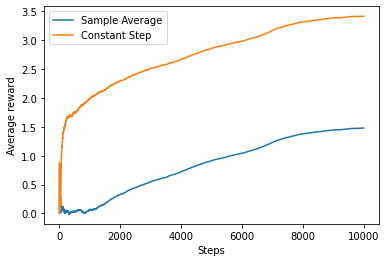

In [6]:
# Average Reward
reward = matplotlib.pyplot.figure(1)
matplotlib.pyplot.ylabel("Average reward")
matplotlib.pyplot.xlabel("Steps")
matplotlib.pyplot.plot(rewards_sam, label="Sample Average")
matplotlib.pyplot.plot(rewards_css, label= "Constant Step")
matplotlib.pyplot.legend()

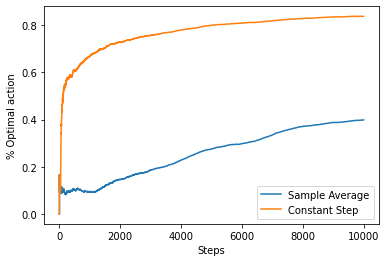

In [7]:
# Average Optimal Choice
optimal_choice = matplotlib.pyplot.figure(2)
matplotlib.pyplot.ylabel("% Optimal action")
matplotlib.pyplot.xlabel("Steps")
matplotlib.pyplot.plot(optimal_sam, label= "Sample Average")
matplotlib.pyplot.plot(optimal_css, label= "Constant Step")
matplotlib.pyplot.legend()